# Data Analysis for data scraped with `scrapeData.py`
This notebook calculates the PE ratio for the TA-35 index.
The earnings per share and the PE ratio are calculated and compared with the scraped data in order to validate the calculations.

To calculate the earnings for a single company, it is important to take the trailing twelve months earnings per share. For June 2024, this can be calculated as follows:
$$\mathrm{Net\ Income} = \mathrm{Net\ Income\ (June \ 2024)} + (\mathrm{Net\ Income\ (Annual \ 2023)} - \mathrm{Net\ Income\ (June \ 2023)})$$
Sometimes, the annual net incomes for two years are available. For example in February 2026, we could be given Anual 2025 and Annual 2024 net incomes. In this case, the trailing twelve months earnings can be calculated as:
$$\mathrm{Net\ Income} = \mathrm{Net\ Income\ (Annual \ 2025)}$$

These values for the trailing twelve months earnings can then be used to calculate the PE ratio for the entire fund:
$$\mathrm{PE\ Ratio} = \frac{\sum \mathrm{Market\ Cap}_i \cdot w_i}{\sum \mathrm{Net\ Income}_i \cdot w_i}$$
where $w_i$ is the weight of the $i$-th company in the fund.


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

today = datetime.date.today()
# today = datetime.datetime(year=2025, month=12, day=1)
download_dir = Path.cwd() / 'data' / today.strftime('%d%m%Y')

In [2]:
file = download_dir / 'dailyreviewforeignexchange.csv'
df = pd.read_csv(file, header=2, index_col=0)
usd_to_ils = df.loc['U.S Dollar', 'Exchange Rate']

In [3]:
file = download_dir / 'indexcomponents.csv'
df = pd.read_csv(file, header=2)
df.columns = df.columns.str.strip()  # remove space from column names
# df = df[['Symbol', 'Security No', 'Weight (%)', 'Base Price (0.01 NIS)',
#          'Market Cap (NIS millions)', 'Closing Price (0.01 NIS)']]
# df['Base Price'] = df['Base Price (0.01 NIS)']
# df['Market Cap'] = df['Market Cap (NIS millions)'] * 1e6
df = df[['Symbol', 'Security No', 'Weight (%)', 'Base Price (0.01 ILS)',
         'Market Cap (M ILS)', 'Closing Price (0.01 ILS)']]
df['Base Price'] = df['Base Price (0.01 ILS)']
df['Market Cap'] = df['Market Cap (M ILS)'] * 1e6
df.drop(columns=['Base Price (0.01 ILS)', 'Market Cap (M ILS)'], inplace=True)
df['Shares'] = df['Market Cap'] / df['Base Price']

In [4]:
df_currency = pd.read_csv(download_dir / 'currency.csv', header=None)
df_currency.head()

symbol_to_currency = {}
for i in range(len(df_currency)):
    symbol = df_currency[0].iloc[i]
    currency = df_currency[1].iloc[i]
    symbol_to_currency[symbol] = currency

In [5]:
net_income_year = []
net_income_half_year = []
earnings_per_share = []
pe_ratio = []
dividends = []

for i in range(len(df)):
    symbol = df['Symbol'].iloc[i]
    file = download_dir / f'{symbol}FinanceReport.csv'

    df_company = pd.read_csv(file, header=0).T
    currency = symbol_to_currency[symbol]
    multiplier = usd_to_ils if (currency == 'USD') else 1
    df_company = pd.read_csv(file, header=1).T
    df_company = df_company.iloc[:, 1:]
    df_company.columns = df_company.iloc[0]
    df_company = df_company[1:]

    cols = ['Income Attributable to Shareholders', 'Net Income', 'Net profit']
    found = False
    for col in cols:
        if col in df_company.columns:
            nr_rows = df_company.shape[0]
            values = [df_company.iloc[[i]][col].item() for i in range(nr_rows)]
            values = [float(value.replace(',', '')) * multiplier for value in values]
            if nr_rows == 3:
                net_income_year.append(values[0] + values[2] - values[1])
            else:
                net_income_year.append(values[0])
            net_income_half_year.append(values[0])
            found = True
            break

    if not found:
        raise ValueError('Net Income not found for ' + symbol)

    df_company = df_company.iloc[[0]]
    earnings_per_share.append(float(df_company['Earnings per Share'].item().replace(',', '')) * multiplier)
    foo = df_company['Price-Earning Ratio'].item()
    foo = float(foo) if foo != 'Loss' else np.nan
    pe_ratio.append(foo)
    dividends.append(float(df_company['Dividends'].item().replace(',', '')) * multiplier)

df['Net Income (year)'] = np.array(net_income_year) * 1000
df['Net Income (half year)'] = np.array(net_income_half_year) * 1000
df['Earnings per Share'] = np.array(earnings_per_share) * 1000 / 10  # correction
df['PE Ratio'] = np.array(pe_ratio)
df['Dividends'] = np.array(dividends) * 1000

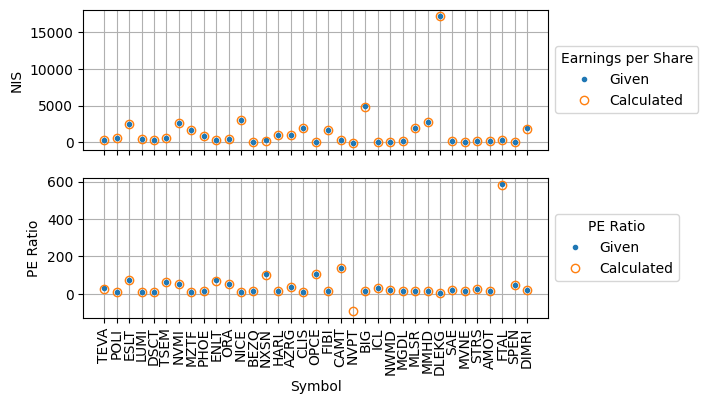

In [6]:
eps_half_year = df['Net Income (half year)'] / df['Shares']
fig, axs = plt.subplots(2,1, figsize=(6,4), sharex=True)

ax = axs[0]
ax.plot(range(len(df)), df['Earnings per Share'], '.', label='Given')
ax.plot(range(len(df)), eps_half_year, 'o', mfc='none', label='Calculated')
ax.set_ylabel('NIS')
ax.legend(title='Earnings per Share', loc='center left', bbox_to_anchor=(1, 0.5))

eps_year = df['Net Income (year)'] / df['Shares']
pe_ratio = df['Base Price'] / eps_year
ax = axs[1]
ax.plot(range(len(df)), df['PE Ratio'], '.', label='Given')
ax.plot(range(len(df)), pe_ratio, 'o', mfc='none', label='Calculated')
ax.set_xlabel('Symbol')
ax.set_xticks(range(len(df)))
ax.set_xticklabels(df['Symbol'], rotation=90)
ax.set_ylabel('PE Ratio')
ax.legend(title='PE Ratio', loc='center left', bbox_to_anchor=(1, 0.5))

for ax_ in axs:
    ax_.grid()

Note: the scraped PE ratio for a company at loss is not registered. This notebook allows for the calculation of the PE ratio for such companies and is taken into account in the calculation of the fund PE ratio.

In [7]:
# Weighted average of prices to weighted average of earnings
fund_pe_ratio = (df['Market Cap'] * df['Weight (%)']).sum() / (df['Net Income (year)'] * df['Weight (%)']).sum()
print(f'Fund PE Ratio: {fund_pe_ratio:.1f}')

Fund PE Ratio: 18.2


In [8]:
# save the PE ratio in a CSV file
csv_file = Path.cwd() / 'pe_ratio.csv'

if not csv_file.exists():
    df = pd.DataFrame(columns=['Date', 'Fund PE Ratio'])
    df.to_csv(csv_file, index=False)

df = pd.read_csv(csv_file)
if today.strftime('%Y-%m-%d') not in df['Date'].values:
    new_row = {'Date': today.strftime('%Y-%m-%d'), 'Fund PE Ratio': fund_pe_ratio}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df.to_csv(csv_file, index=False)

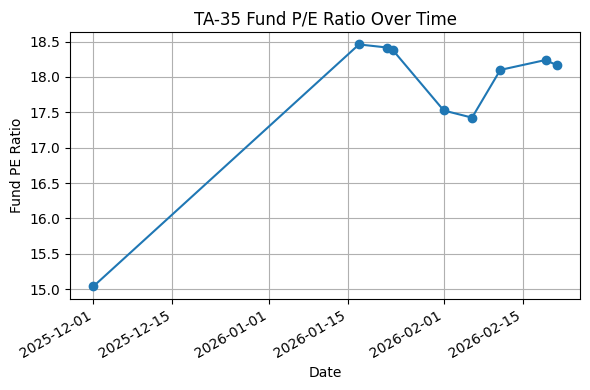

In [9]:
# make a plot of the PE ratio over time
df = pd.read_csv(csv_file)
df['Date'] = pd.to_datetime(df['Date'])
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(df['Date'], df['Fund PE Ratio'], '-o')
ax.set_xlabel('Date')
ax.set_ylabel('Fund PE Ratio')
ax.grid()
ax.set_title('TA-35 Fund P/E Ratio Over Time')
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig(Path.cwd() / 'pe_ratio.png', dpi=600)